# Combined Kriging Class

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy.stats
from scipy import spatial
from scipy import optimize
from scipy import special
import time
from scipy.spatial.distance import cdist

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
class Kriging(object):
    # What do I want: 
    # passing: Data with properties, layer, geo_data --> meaning that I have to cut everything in here! - check
    # --- this is basically done 
    # possibility to read in data - check gempy how to do best
    # --- if data has own xyz coordinates I need to fit them to grid
    # analyzing data part needs to be in here somewhere, have to check how "OK" that is,
    # --- includes histogram and variogram building as well as fitting a function and converting to covariance function
    # --- and if I can switch between covariance function (SK) and variogram function (OK, UK) in a reasonable manner
    # Selection:
    # SK, OK, UK
    # --- SK needs covariance function instead of variogram function - check
    # --- UK needs completely different setup as I need the coordinates of eacht point in Kriging matrices - check
    # cdist or my distance
    # --- need to set up my distance calculation properly also maybe with several planes as suggested by Florian
    # SGS or not?
    def __init__(self, data, geomodel, grid, formation_number, kriging_type=None):
        # here I want to put the basic variables and also the data analysis - or maybe even everything?!
        
        self.geomodel = geomodel
        self.grid = grid
        self.formation_number = formation_number
        self.data = data
        
        # Basic input data parameters for SK 
        self.inp_mean = np.mean(data['Property'])
        self.inp_var = np.var(data['Property'])
        self.inp_std = np.sqrt(self.inp_var)
        
        # Set default Kriging type to OK
        if kriging_type is None:
            kriging_type = 'OK'
        self.kriging_type = kriging_type
        
        
        t_init1 = time.time()
        #PART 1: Initializing data and domain
        # set domain data
        self.grid_dataframe = self.init_domain()
        # set property data (finally needs to be an 2d array with index in grid_dataframe and value)
        self.property_data = self.match_data_positions() #hier schraube ich gerade
        t_init2 = time.time()
        print("initializing:", t_init2-t_init1)
        
        #PART 2: Analyzing the data - mainly getting a variogram/covariance function 
        # best case, only do that if not done before, so only of nothing is specified in keywords
        # preset everything for now, maybe make this optional later, either pass sill, range, model, and nugget
        # or make scipy bestfit
        self.model = 'gaussian'
        self.range_ = 169
        self.sill = 38
        self.nugget = 5
        
        #PART 3: Acutally performing Kriging 
        self.kriging_result, self.result_coord = self.sgs() 
        
    
    #def get_data():
        # method to read data from given csv and create pandas dataframe
        # question if this is really necessary, or if passing a pandas dataframe is sufficient
        
    def init_domain (self):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        reduced to a certain formation of interest. Thus as of now, Kriging is only possible within one layer of the
        model. Allowing multiple layers or the whole model should not be too difficult if required.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation_number (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, meaning xyz of each grid point.
        """
    
        # convert lith block values to int, thats what Miguel suggested --> maybe a better solution required
        geomodel_int = np.round(self.geomodel[0])
    
        # create the dataframe and populate with data
        d = {'X': self.grid.values[:,0], 'Y': self.grid.values[:,1], 'Z': self.grid.values[:,2], 'lith': geomodel_int}
        dataframe_aux = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        grid_dataframe = dataframe_aux.loc[dataframe_aux['lith'] == self.formation_number]
        grid_dataframe = grid_dataframe.reset_index() # reset indicies
        del grid_dataframe['index'] # reset indices

        return grid_dataframe
    
    def match_data_positions(self):
        '''
        Method to match XYZ coordinates of measured property data to grid points, as distances are computed 
        grid points. Right now also points outside the specified domain are projected onto the grid. Maybe add
        if clause for greater distances.
        Args:
            data (pandas.dataframe): dataframe containing xyz coordinates and property values
            grid_dataframe: containing xyz of grid coordinates
        Returns
            data_pos(np.array)(2,n) = array containing grid index [0] and corresponding property value [1]
            '''
        # extracting required data
        prop_coord = self.data.as_matrix(('X','Y','Z'))
        values = data.as_matrix(('Property',))
        coord3d = np.delete(self.grid_dataframe.values, 3, 1)
        
        # empty aray for results
        data_pos = np.zeros((len(values), 2))
        
        # finding closest grid point for each data value
        for i in range (len(data)):
            closest = np.argmin(cdist(prop_coord[i].reshape(1,3), coord3d))
            data_pos[i][0]= closest
            data_pos[i][1]= values[i]
        
        # workaround for rounding - hast to be optimized
        data_pos = data_pos.astype(int)
        data_pos = np.swapaxes(data_pos,0,1)
        
        return data_pos
    
            #def analyse_data():
        # method for getting mean, std, etc. of the given dataset
        
    def precalculate_distances(self, prop_data, sgs_check, grid_coord):
        
        # order grid by indices given in prop_data[0] and sgs check
        aux = np.append(prop_data[0], sgs_check)
        grid_reordered = grid_coord[aux]
        
        if self.distance_type == 'euclidian':
            # perform cdist - easy and fast for straight distances
            dist_matrix = cdist(grid_reordered, grid_reordered)
        elif self.distance_type == 'deformed':
            
            

        return dist_matrix, grid_reordered
    
    def gaussian_variogram_model(self, d):
        psill =self.sill-self.nugget
        gamma = psill * (1. - np.exp(-d**2./(self.range_)**2.))+self.nugget
        return gamma
    
    def gaussian_covariance_model(self, d):
        # variance normed to values
        self.sill = self.inp_var/self.inp_mean
        gamma = self.sill * (np.exp(-d**2./(self.range_)**2.))
        return gamma
    
    def simple_kriging(self, a, b, prop):
        
        # !!! SK still needs work: result only works with diagonal (nugget effect???) fill of 10 and covariance 
        # function seems more than shady ... but choosing kriging type works for all three options now
        # Also SGS does only work with scale = 0 so does not really wor at all :/

        # empty matrix buildung
        shape = len(a)
        C = np.zeros((shape, shape))
        c = np.zeros((shape))
        w = np.zeros((shape))

        # Faster matrix building approach, no loops
        C[:shape, :shape] = self.gaussian_covariance_model(b)
        c[:shape] = self.gaussian_covariance_model(a)

        # nugget effect
        np.fill_diagonal(C, 10)

        w = np.linalg.solve(C,c)

        # SGS version - taking result from normal distribution with kriging mean an standard deviation
        #result = np.random.normal(inp_mean + np.sum(w * (prop-inp_mean)), scale = 0) #scale=np.sqrt(variance-np.sum(w*c)))
        # if I use other scale it gets wild

        # direct version, calculating result from weights. Need to be normed to one
        result = self.inp_mean + np.sum(w * (prop-self.inp_mean))

        return result

    def ordinary_kriging(self, a, b, prop):
        
        # empty matrix building
        shape = len(a)
        C = np.zeros((shape+1, shape+1))
        c = np.zeros((shape+1))
        w = np.zeros((shape+1))

        # Faster matrix building approach, no loops
        C[:shape, :shape] = self.gaussian_variogram_model(b)
        c[:shape] = self.gaussian_variogram_model(a)

        # matrix setup - compare pykrige, special for OK
        np.fill_diagonal(C, 0) # is that OK?
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0  
        c[shape] = 1.0

        # Solve Kriging equations
        w = np.linalg.solve(C,c)

        # SGS version - need to get mean and std
        #result = np.random.normal(np.sum(w[:shape] * prop), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))

        # direct version, calculating result from weights.
        result = np.sum(w[:shape] * prop)

        return result
    
    def universal_kriging(self, a, b, prop, coord, target_coord):

        # empty matrix building
        shape = len(a)
        C = np.zeros((shape+1, shape+1))
        c = np.zeros((shape+1))
        w = np.zeros((shape+1))

        # Faster matrix building approach, no loops
        C[:shape, :shape] = self.gaussian_variogram_model(b)
        c[:shape] = self.gaussian_variogram_model(a)

        # matrix setup - compare pykrige
        np.fill_diagonal(C, 0) # is that OK
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0  
        c[shape] = 1.0

        # additional matrices for universal kriging, containing Coordinates and zeros
        aux1 = np.vstack((coord, np.zeros((1, 3))))
        aux2 = np.hstack((np.transpose(coord), np.zeros((3,4))))

        # adding auxiliary matrices to the kriging matrices
        C = np.hstack((C, aux1))
        C = np.vstack((C, aux2))
        c = np.hstack((c, target_coord))

        # Solve Kriging equations
        w = np.linalg.solve(C,c)

        # SGS version - in UK case the scale (standard deviation) is not yet implemented/correct
        #result = np.random.normal(np.sum(w[:shape] * data_v), scale=np.sqrt(w[shape]-gaussian_variogram_model(0)+np.sum(w[:shape]*c[:shape])))

        # direct version, calculating result from weights.
        result = np.sum(w[:shape] * prop)

        return result
    
    def get_distance_matrices(self, dist_matrix, n, prop_data, subcoord):
        """
        Method to get closest points out of distance matrix calculated beforehand.
        Args:
            dist_matrix (np.array): matrix of distances between existing property data points
            n(int): number of closest points used 
            prop_data(np.array)(n,2): array containing indexes of property data in grid and corresponding values
        Returns
            dist_close_all_to_all (n,n): matrix of distances between all selected closest points
            dist_close_target_to_all (n,): distances between target point and selected closest points
        """
        #index of target point, follows growth of dist matrix, as randomization is done before
        target_point = len(dist_matrix)-1

        # check for n closest points in matrix (minimum distance values) and sort the resulting index array
        ind = np.argpartition(dist_matrix[target_point], n+1)[:n+1]
        sort_ind = np.sort(ind)

        # create new property array to match property data to correct indices
        ind_aux_prop = sort_ind[:len(sort_ind)-1]
        closest_prop_data = prop_data[1][ind_aux_prop]
        
        # only for UK also match coordinates
        closest_coord_data = subcoord[ind_aux_prop]

        # extract distances from target point (row of target index - now last row of matrix) without last entry (target)
        dist_close_target_to_all = dist_matrix[target_point][sort_ind]
        dist_close_target_to_all = dist_close_target_to_all[:len(dist_close_target_to_all)-1]

        # extract distance each to each for those closest points, delete target point index row and column
        dist_close_all_to_all = dist_matrix[np.ix_(sort_ind[:len(sort_ind)-1],sort_ind[:len(sort_ind)-1])]
        
        return dist_close_target_to_all, dist_close_all_to_all, closest_prop_data, closest_coord_data

    def sgs(self):
        
        # copy data to leave original data unchanged
        grid_coord = self.grid_dataframe.values[:, :-1]
        prop_data = self.property_data
    
        # just for progress bar
        runs = len(grid_coord)-len(prop_data[0])

        # for timing purposes
        time_prec = 0
        time_sub = 0
        time_dist = 0
        time_krig = 0

        # create array to go through SGS, only containing indices of grid points without data
        sgs_check = np.arange(0,len(grid_coord))
        sgs_check = np.delete(sgs_check, prop_data[0])
    
        # randomize it to predefine SGS way
        np.random.shuffle(sgs_check)

        # precalculate distances in matrix and sgs order, as well as coordinates in sgs order (for UK only)
        t_pre1 = time.time()
        dist_matrix_sgs_order, coord_sgs_order = self.precalculate_distances(prop_data, sgs_check, grid_coord)
        t_pre2 = time.time()
        print("distance precalculation:", t_pre2-t_pre1)

        # set initial length of property data frame
        start = len(prop_data[0])

        for i in range(0, len(sgs_check)):

            # choose first point from sgs_check, as this is already randomized
            target_point = sgs_check[i]
            # for UK coordinate of target point
            target_coord = grid_coord[sgs_check[i]]

            t0 = time.time()
            # extract submatrix required for distances, containing only grid points with property values
            submatrix = dist_matrix_sgs_order[0:start+i+1,0:start+i+1] 
            
            # for UK only to transfer coordinates:
            subcoord = coord_sgs_order[0:start+i+1]

            t1 = time.time()
            time_sub = time_sub+(t1-t0)
            # get closest distances
            # a, b, prop = self.get_distance_matrices(submatrix, 50, prop_data)
            # for UK version:
            a, b, close_prop, close_coord = self.get_distance_matrices(submatrix, 50, prop_data, subcoord)

            t2 = time.time()
            time_dist = time_dist+(t2-t1)
            # perform the Kriging interpolation on this point
            
            if self.kriging_type == 'OK':
                kriging_result = self.ordinary_kriging(a , b, close_prop)
            elif self.kriging_type == 'UK':
                kriging_result = self.universal_kriging(a , b, close_prop, close_coord, target_coord)
            elif self.kriging_type == 'SK':
                kriging_result = self.simple_kriging(a, b, close_prop)
            else:
                print('ERORR - Kriging Type not understood')

            t3 = time.time()
            time_krig = time_krig+(t3-t2)

            # add point to property data list
            prop_data = np.hstack((prop_data, ([[target_point], [kriging_result]])))
            #prop_data = np.round(prop_data) # just for now

            #use of progress bar ...
            #updt(runs,i+1)

            
        # print(prop_data.shape)   
        # sort the results properly at the end - needs to be optimized for not rounding it 
        #prop_data = np.round(prop_data) # just for now
        #prop_data = sorted(np.swapaxes(prop_data,0,1), key=lambda row: row[0])
        #prop_data = np.vstack(prop_data)
        #prop_data = np.swapaxes(prop_data,0,1)
        result_coord = np.swapaxes(coord_sgs_order, 0,1)
    
        print("submatrix extraction:", time_sub)
        print("distance Matrices:", time_dist)
        print("kriging calculation:", time_krig)

        return prop_data, result_coord

IndentationError: expected an indented block (<ipython-input-1-fa4cc2a819fc>, line 136)

In [3]:
# more complex test run with the data I used before
# domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")

variogram_fit = pd.read_csv("variogram_fit.csv")


In [4]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [6]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [53]:
test = Kriging(data, lith_block, geo_data.grid, formation_number=3, kriging_type='OK')

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


initialize: 0.031248092651367188
distance precalculation: 0.1562342643737793
submatrix extraction: 0.0
distance Matrices: 0.48433923721313477
kriging calculation: 0.5937175750732422


In [54]:
test.kriging_result.shape
coord3d_aux = test.grid_dataframe.values
coord3d_aux = np.delete(coord3d_aux, 3, 1)
coord3d_aux = np.swapaxes(coord3d_aux, 0,1) # for plotting later

In [55]:
import matplotlib as mpl

# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

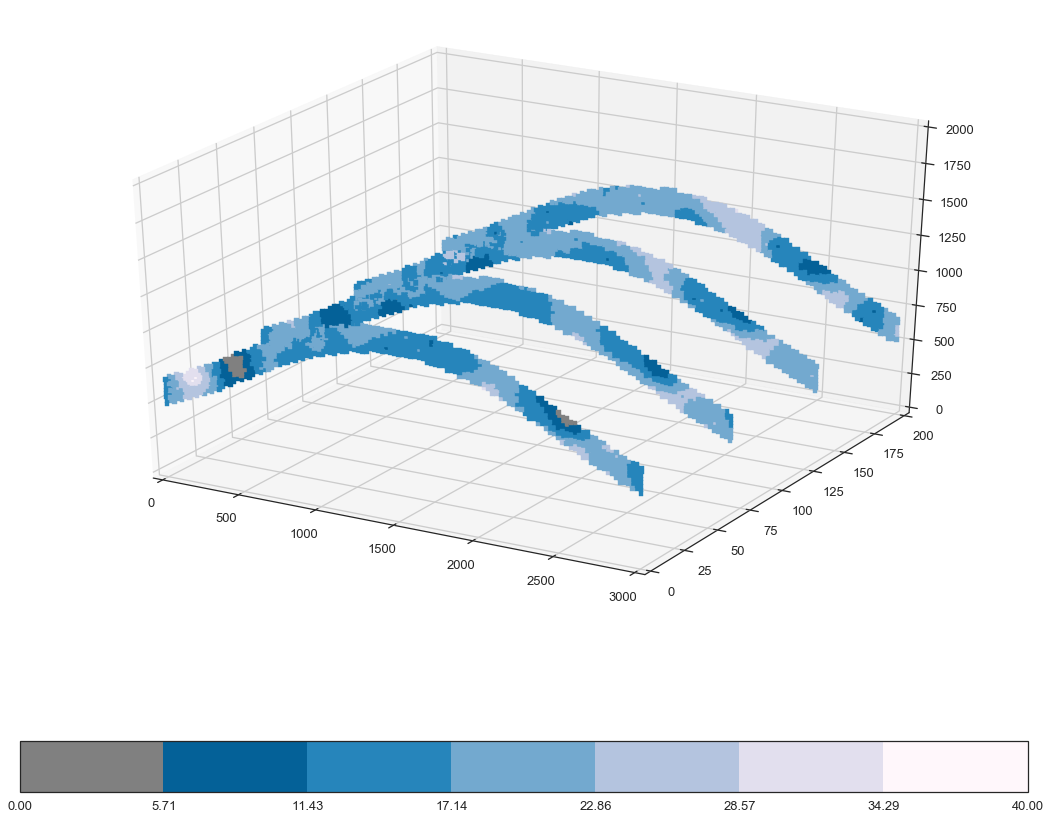

In [56]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)

ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
a = ax.scatter3D(xs=test.result_coord[0],ys=test.result_coord[1],zs=test.result_coord[2], c=test.kriging_result[1], s=20, marker=',', cmap=cmap, norm=norm, alpha=1)
#b = ax.scatter3D(xs=test.result_coord[0][:200],ys=test.result_coord[1][:200],zs=test.result_coord[2][:200], c=test.kriging_result[1][:200], s=20 ,marker=',', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')
#c = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

fig.colorbar(b, orientation='horizontal')